In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [3]:
ds_train = datasets.CIFAR10("~/share/data/", train=True, download=False, transform=transform)
ds_test = datasets.CIFAR10("~/share/data/", train=False, download=False, transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(ds_train, batch_size=512,
                                         num_workers=2, shuffle=True)

In [5]:
testloader = torch.utils.data.DataLoader(ds_test, batch_size=512, 
                                        num_workers=2, shuffle=False)

In [6]:
batch_X, batch_y = iter(trainloader).next()

In [7]:
batch_X.size()

torch.Size([512, 3, 32, 32])

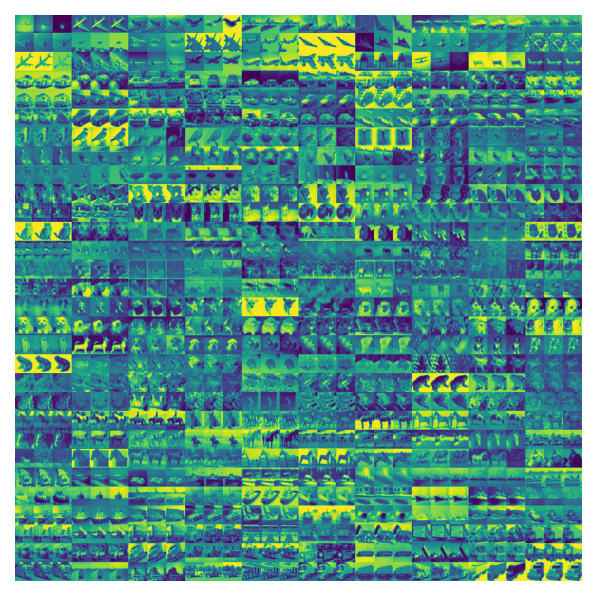

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=150)
plt.axis('off')

plt.imshow(
    torch.transpose(
        torch.cat(
            [batch_X[batch_y==c][:30] for c in range(30)], axis=0
        ).reshape(30, 30, 32, 32),
        1, 2
    ).reshape(960, 960)
)
plt.show()

In [9]:
device = print('cuda' if torch.cuda.is_available() else 'cpu')
device

cuda


In [10]:
batch_y.size()

torch.Size([512])

In [11]:
model = nn.Sequential(
    nn.Linear(3072, 500),
    nn.ReLU(),
    #nn.Linear(2500, 1000),
    #nn.ReLU(),
    #nn.Linear(1000, 100),
    #nn.ReLU(),
    nn.Linear(500, 10),
).to(device)

for w in model.parameters():
    print(' ', w.size())

  torch.Size([500, 3072])
  torch.Size([500])
  torch.Size([10, 500])
  torch.Size([10])


In [12]:
def flatten_trailing(batch):
    flat = batch.flatten(1)
    return flat

In [13]:
prediction = model(flatten_trailing(batch_X.to(device)))

In [14]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(prediction, batch_y.to(device))
loss

tensor(2.3047, grad_fn=<NllLossBackward>)

In [15]:
for i in range(3):
    print(model[i])

Linear(in_features=3072, out_features=500, bias=True)
ReLU()
Linear(in_features=500, out_features=10, bias=True)


In [16]:
print('Before backward \n', model[0].weight.grad)

Before backward 
 None


In [17]:
#loss.backward()
#print('After gradient \n', model[0].weight.grad)

In [20]:
import tqdm
from IPython.display import clear_output 

In [21]:
def train_loop(model, num_epochs=1, batch_size=512, loss_function = loss_fn, device='cpu'):
    train_losses = []
    test_losses = []
    test_accuracy = []
    model_div = model.to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=0.0002)
    loss_fun = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        t = tqdm.tqdm(iter(trainloader), leave=False, total=len(trainloader))
        for idx, data in enumerate(t):
            X_batch, y_batch = map(lambda x: x.to(device), data)
            #X_batch = torch.tensor(X, requires_grad=True, dtype=torch.float64)
            #y_batch = torch.tensor(y, requires_grad=True, dtype=torch.float64)
            
            loss = loss_fn(model(flatten_trailing(X_batch)), y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
            train_losses.append(loss.item())
        
        test_X, test_y = map(lambda x: x.to(device), iter(testloader).next())
    
        test_prediction = model(flatten_trailing(test_X))
        test_losses.append(
            loss_fn(test_prediction, test_y).item()
        )
    
        test_accuracy.append(
            (test_prediction.argmax(axis=1)==test_y).to(float).mean()
        )
    
        clear_output(wait=True)
    
        print('Accuracy: ', max(test_accuracy))
        plt.figure(figsize=(8, 3), dpi=100)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='train')
        plt.plot(
            np.linspace(0, len(train_losses), len(test_losses) + 1)[1:],
            test_losses, label='test'
        )
        plt.ylabel("Loss")
        plt.xlabel("# steps")
        plt.legend();

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracy, "o-")
        plt.ylabel("Test accuracy")
        plt.xlabel("# epochs");
        plt.show()
    return train_losses, test_losses, test_accuracy

Accuracy:  tensor(0.5254, dtype=torch.float64)


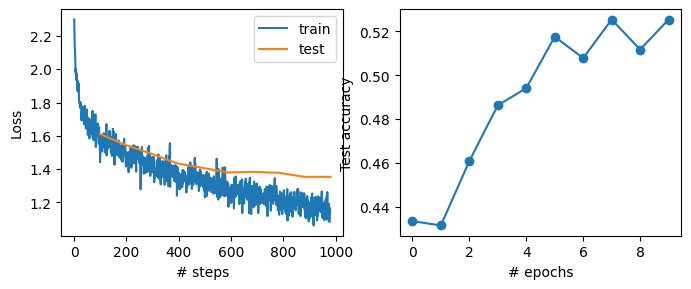

([2.298297643661499,
  2.208897590637207,
  2.138077735900879,
  2.10833477973938,
  2.063884973526001,
  1.9806855916976929,
  2.001171827316284,
  1.9839394092559814,
  1.982338309288025,
  1.9319854974746704,
  1.9690461158752441,
  1.9343417882919312,
  1.8717293739318848,
  1.8925701379776,
  1.9285211563110352,
  1.8655425310134888,
  1.8834507465362549,
  1.9156397581100464,
  1.8388841152191162,
  1.804255723953247,
  1.8045415878295898,
  1.7896136045455933,
  1.788148045539856,
  1.8024007081985474,
  1.7658045291900635,
  1.7965530157089233,
  1.7777167558670044,
  1.7833020687103271,
  1.6925053596496582,
  1.7476928234100342,
  1.7404277324676514,
  1.6985615491867065,
  1.7530910968780518,
  1.7456072568893433,
  1.7732679843902588,
  1.773489236831665,
  1.754460096359253,
  1.689467191696167,
  1.6693718433380127,
  1.7400922775268555,
  1.7657088041305542,
  1.7793864011764526,
  1.705348014831543,
  1.706968903541565,
  1.6496937274932861,
  1.6433887481689453,
  1.72

In [20]:
train_loop(model, num_epochs=10, device=device)

In [22]:
torch.cuda.is_available()

True

In [23]:
torch.cuda.get_device_name()

'NVIDIA GeForce 940MX'

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3072, 1500)
        self.fc2 = nn.Linear(1500, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, X):
        Xf = X.flatten(1)
        X1 = F.relu(self.fc1(Xf))
        X2 = F.relu(self.fc2(X1))
        return self.fc3(X2)

In [25]:
model2 = Net().to(device)

Accuracy:  tensor(0.5469, dtype=torch.float64)


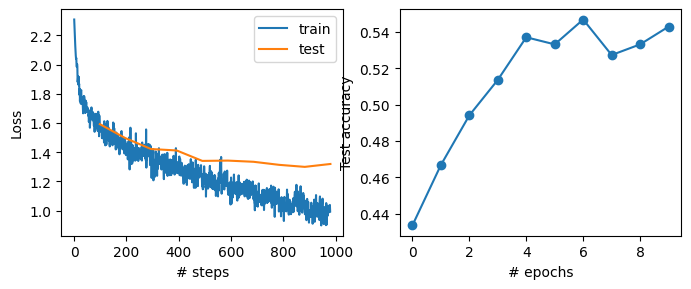

([2.308370590209961,
  2.259734630584717,
  2.196828603744507,
  2.162931203842163,
  2.1289424896240234,
  2.087372303009033,
  2.0608677864074707,
  2.0399842262268066,
  2.045339345932007,
  1.996482014656067,
  1.9834438562393188,
  2.0031211376190186,
  1.9882824420928955,
  1.8811612129211426,
  1.8939082622528076,
  1.9203195571899414,
  1.8627794981002808,
  1.9159655570983887,
  1.8584721088409424,
  1.86726975440979,
  1.7929744720458984,
  1.8337199687957764,
  1.748534917831421,
  1.8128684759140015,
  1.7841185331344604,
  1.7339000701904297,
  1.8206696510314941,
  1.8252462148666382,
  1.7299846410751343,
  1.7584940195083618,
  1.7339223623275757,
  1.7390247583389282,
  1.7603607177734375,
  1.7170735597610474,
  1.6663089990615845,
  1.7347235679626465,
  1.782636284828186,
  1.6874703168869019,
  1.7831909656524658,
  1.7692497968673706,
  1.6824344396591187,
  1.671546459197998,
  1.6991995573043823,
  1.6699556112289429,
  1.753014326095581,
  1.7139041423797607,
 

In [25]:
train_loop(model2, num_epochs=10)

## Tensorboard 

In [59]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # default dir: ./runs/MNIST_Y
# a directory we use to store the intermediate information . 
# everything is sent there.

In [60]:
train_X, train_y = map(lambda x: x.to(device), iter(trainloader).next())

In [61]:
img = torch.transpose(
        torch.cat(
            [train_X[train_y==c][:30] for c in range(10)], axis=0
        ).reshape(30, 30, 32, 32),
    1, 2
).reshape(960, 960)

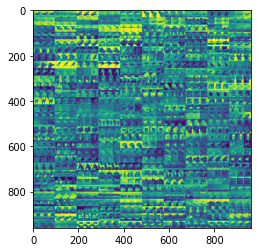

torch.Size([960, 960])


In [62]:
plt.imshow(img)
plt.show()
print(img.shape)

Let's send these information to **tensorboard**

In [63]:
writer.add_image('MNIST', img.view(1, 960, 960))

In [64]:
writer.close()

In [67]:
# ! pip install tensorboard

Now we have to run tensorboard in a separate terminal using the script: `$ tesnorboard --logdir=runs`

In [66]:
! tensorboard --logdir=runs 
# it will show you binary B & W images 

2021-08-14 11:36:32.719442: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
